## Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

root = './'
# root = 'C:/Data/instacart-market-basket-analysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4283.495386123657  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1188.0639028549194  MB
This is  27.73585111597508 % of the initial size


In [6]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [7]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [8]:
df.shape

(8474661, 68)

In [9]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [10]:
X = df[x_cols]
y = df[label]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [12]:
y_train.value_counts()

reordered
0.0    5734377
1.0     621618
Name: count, dtype: int64

In [13]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [14]:
y_test.value_counts()

reordered
0.0    1911460
1.0     207206
Name: count, dtype: int64

In [15]:
# freeing memory
del df, X, y
gc.collect()

190

### Neural Network model

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

In [20]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [21]:
input_dim =  X_train_sc.shape[1]
input_dim

67

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
history = History()

classifier = Sequential()

classifier.add(Dense(units = 64, activation = 'relu', input_dim = input_dim))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 1, activation ='sigmoid'))

classifier.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy', f1_m, precision_m, recall_m])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4352      
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
 dense_2 (Dense)             (None, 4)                 64        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5396 (21.08 KB)
Trainable params: 5396 (21.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
%%time
# fit the model
classifier.fit(X_train_sc, y_train, epochs=50, batch_size=512, validation_split=0.15, verbose=1,class_weight= {0:1, 1:10},
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/50
10552/10552 [==============================] - 22s 2ms/step - loss: 0.9669 - accuracy: 0.7328 - f1_m: 0.3577 - precision_m: 0.2361 - recall_m: 0.7583 - val_loss: 0.5365 - val_accuracy: 0.7389 - val_f1_m: 0.3630 - val_precision_m: 0.2390 - val_recall_m: 0.7636
Epoch 2/50
10552/10552 [==============================] - 19s 2ms/step - loss: 0.9560 - accuracy: 0.7334 - f1_m: 0.3604 - precision_m: 0.2369 - recall_m: 0.7684 - val_loss: 0.5597 - val_accuracy: 0.7229 - val_f1_m: 0.3554 - val_precision_m: 0.2306 - val_recall_m: 0.7840
Epoch 3/50
10552/10552 [==============================] - 18s 2ms/step - loss: 0.9533 - accuracy: 0.7346 - f1_m: 0.3614 - precision_m: 0.2376 - recall_m: 0.7691 - val_loss: 0.5121 - val_accuracy: 0.7512 - val_f1_m: 0.3714 - val_precision_m: 0.2473 - val_recall_m: 0.7547
Epoch 4/50
10552/10552 [==============================] - 18s 2ms/step - loss: 0.9514 - accuracy: 0.7348 - f1_m: 0.3619 - precision_m: 0.2378 - recall_m: 0.7706 - val_loss: 0.5483 - val_a

In [25]:
eval_model=classifier.evaluate(X_train_sc, y_train)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])

198625/198625 [==============================] - 176s 885us/step - loss: 0.5095 - accuracy: 0.7534 - f1_m: 0.3557 - precision_m: 0.2496 - recall_m: 0.7301
loss:  0.5095035433769226 and Accuracy:  0.7533871531486511


In [34]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


Text(0.5, 1.0, 'Loss')

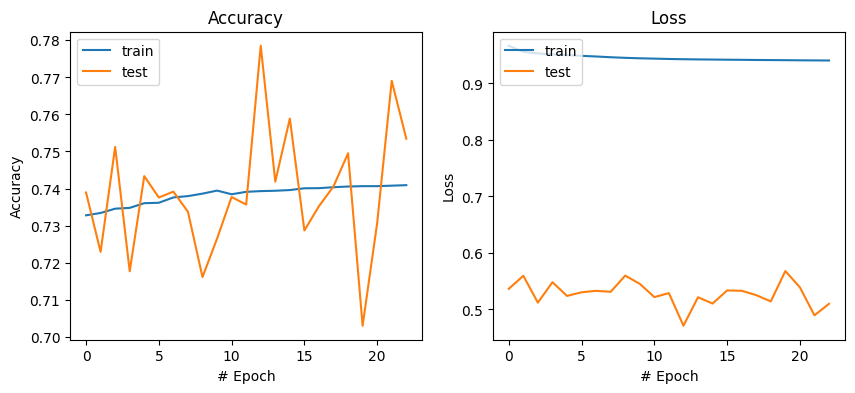

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')

66209/66209 [==============================] - 51s 772us/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.75      0.85   1911460
         1.0       0.25      0.76      0.38    207206

    accuracy                           0.75   2118666
   macro avg       0.61      0.75      0.61   2118666
weighted avg       0.90      0.75      0.80   2118666

Accuracy   Score :  0.7533060897753586
F1 Score:  0.375105212816834
Area under curve :  0.8345247324265549 



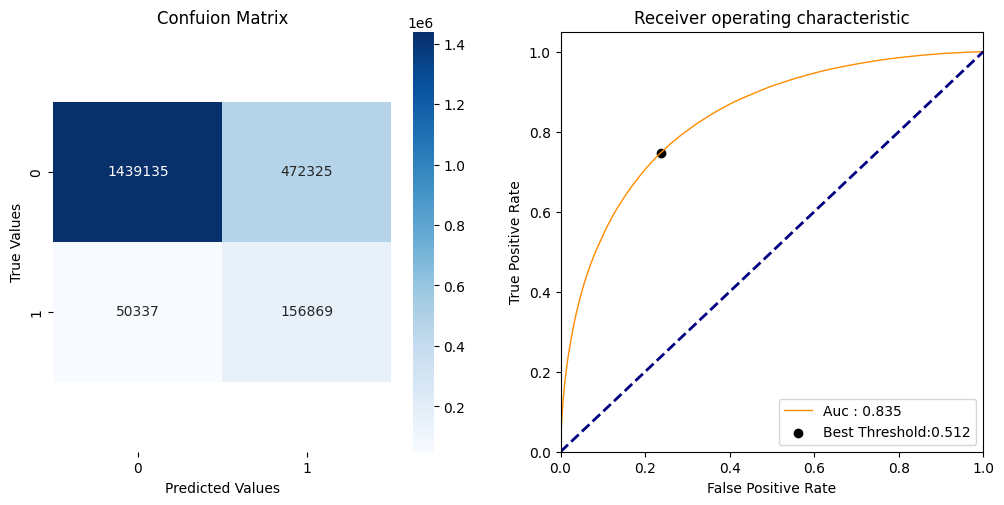

In [39]:
probabilities = classifier.predict(X_test_sc)
predictions = (probabilities > 0.5).astype(int)

print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probabilities[:,0]) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,0])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()